Removed the eta term in the equation of motion

Fixed a few bugs of Petia and Martynas' script.

In the canonical case, we should use the noisy backend 'qasm_simulator' but not the ideal 'statevector_simulator'.

NOTE: comparing the optimizers COBYLA, SPSA, SLSQP, SLSQP always concerges to wrong values and SPSA seems perform the best.

In [1]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.quantum_info.operators import Operator



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction


def get_qubit_op(coordinates):

    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0], 0.0, 0.0] ],
            ["H", [coordinates[1], 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm'):

    
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend, shots=128)
        optimizer = SPSA(maxiter=100)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = SLSQP(maxiter=5)
    else:
        print('Error: simulator should be qasm or exact!')
 
    result = exact_solver(problem,converter)


    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    #vqe_ground = vqe_result.eigenstate perhaps more accurate? Downside: don't get circuit 
    final_params = vqe_result.optimal_parameters 
    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    return vqe_ground, min_eng


# def calc_energy(op,num_part,num_orb,problem,converter):
    
# #     backend = BasicAer.get_backend("statevector_simulator")
#     backend = Aer.get_backend('qasm_simulator') 

#     #no clue why this is needed. Without it the initial state has different # of qubits than the number of qubits in qubit operator
#     # and we get an error. 
#     result = exact_solver(problem,converter)

#     optimizer = SLSQP(maxiter=5)

#         #result = exact_solver(problem,converter)
#         #exact_energies.append(result.total_energies[0].real)
    
#     init_state = HartreeFock(num_orb, num_part, converter)
   
#     var_form = UCCSD(converter,
#                         num_part,
#                         num_orb,
#                         initial_state=init_state)
#     vqe = VQE(var_form, optimizer, quantum_instance=backend)
    
#     vqe_calc = vqe.compute_minimum_eigenvalue(op)
#     vqe_result = problem.interpret(vqe_calc).total_energies[0].real
#     return vqe_result

In [3]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force

def get_psi_0(coordinates, simulator='qasm'):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator)
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
        
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=128)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
       
        #get the expectation value <psi_0|O|psi_0>¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0) 
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        f = sampler.eval().real + rep_eng_plus - rep_eng_minus
        
        forces.append(f*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces



#function to calculate covariance matrix

def calc_cov(coordinates, simulator='qasm'):
    #calculate psi_0 at distances R for hamiltonian H(R)
    psi_0 = get_psi_0(coordinates, simulator)

    #array to hold force components    
    force_components = []
    for i in range(0,m):
        #calculate forces for psi_0    
        forces_i = calc_forces(coordinates,psi_0, simulator)
        print(forces_i)
#         #temp array
#         new_forces = []
#         #transform [[f_x0,f_y0,f_z0],[f_x1,f_y1,f_z1]] to [f_x0,f_y0,f_z0,f_x1,f_y1,f_z1] and append it to force_components
#         for j in range(len(forces_i)):
#             new_forces = np.concatenate((new_forces,forces_i[j]),axis=None)
#         force_components.append(new_forces) 
        force_components.append(forces_i)

    #take the transpose of force_components
    force_components = np.array(force_components).T
    #calculate the covariance matrix
    covariance_matrix = np.cov(force_components)                

    return covariance_matrix

In [4]:
femto = 1.0e-15
angst = 1.0e-10
mass_0 = 1.67e-27
#mass of particle2 (H)
mass_1 = 1.67e-27
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init_0 = 0
v_init_1 = 0

v_init = np.array([v_init_0,v_init_1])

#initial positions of atoms
init_pos = [0, 1]

#integrator timesteps
times = np.arange(0*femto, 15.0*femto, dt)
#coordinate array
coords = [init_pos]
force = []
force_exact = []

#temperature in ?? 
T = 1

#hold v_next
v_next = None

for time in times:
    r = coords[-1]
    (f0,f1) = calc_forces(coords[-1])
    (f0_exact, f1_exact) = calc_forces(coords[-1], simulator='exact')
    force.append(f0)
    force_exact.append(f0_exact)
    COV = calc_cov(r)
    print(COV)
#     eta = np.concatenate((-(f0 - f0_exact)/mass_0,-(f1 - f1_exact)/mass_1),axis=None)
    
    #calculation of force covariance matrix
     
    if time == 0:

        v_next = v_init - 1/(2*T)*np.matmul(COV,v_init)*dt - np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt
        
        r_next = (np.array(r)*angst + dt*v_next)/angst

    else:

        v_next += - 1/(2*T)*np.matmul(COV,v_next)*dt - np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt

        r_next = (np.array(r)*angst + dt*v_next)/angst

    coords.append([r_next[0], r_next[1]])

    print(coords)

/home/yixiaowang/anaconda3/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


[-1.0451773495494315e-08, 8.988711488110249e-09]
[-9.347252975454294e-09, 6.334441409701071e-09]
[-7.568816160613756e-09, 9.562732183678956e-09]
[-9.204544887546302e-09, 8.414690792541177e-09]
[-7.18031604162934e-09, 8.142836856182342e-09]
[-6.161774690152831e-09, 1.0538106855268252e-08]
[-5.847108265117574e-09, 7.841024288183017e-09]
[-8.142836856182704e-09, 6.550274809136884e-09]
[-9.161378207659213e-09, 7.495690849085692e-09]
[-7.8838367768598e-09, 8.285544944090334e-09]
[-8.026544864767915e-09, 5.6740873543579404e-09]
[-7.655149520388177e-09, 7.625190888747204e-09]
[-8.816044768561888e-09, 6.649462025947117e-09]
[-9.43323214401805e-09, 7.840670096972227e-09]
[-8.729711408787709e-09, 7.970170136633618e-09]
[-8.272336895844216e-09, 8.5010241523156e-09]
[[1.46905938e-18 4.01604818e-19]
 [4.01604818e-19 1.51903258e-18]]
[[0, 1], [0.002596472722030834, 0.9978056579143333]]
[-1.0207153828368885e-08, 9.834890620740227e-09]
[-1.0095553977364558e-08, 1.0311035637281894e-08]
[-1.045801377817

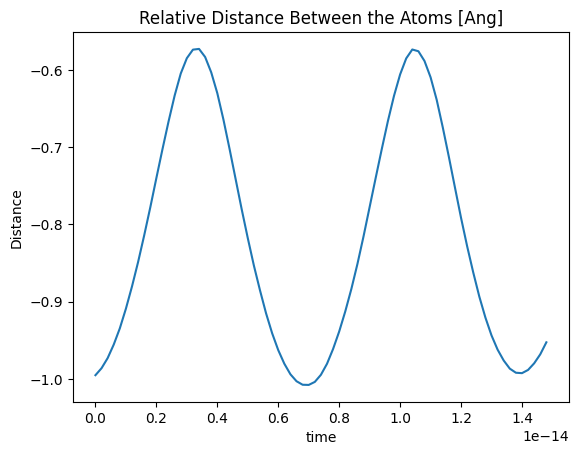

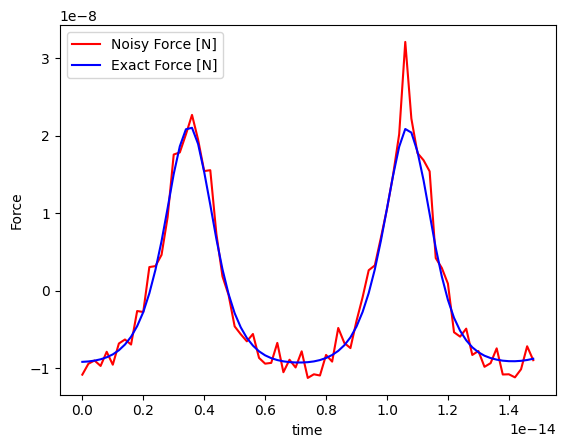

In [5]:
coords_np = np.array(coords)
rel_dist = coords_np[1:,0] - coords_np[1:,1]
plt.plot(times,rel_dist)
plt.title('Relative Distance Between the Atoms [Ang]')
plt.xlabel("time")
plt.ylabel("Distance")
plt.show()

plt.plot(times,force, color='r', label='Noisy Force [N]')
plt.plot(times,force_exact, color='b', label='Exact Force [N]')
plt.xlabel("time")
plt.ylabel("Force")
plt.legend()
plt.show()

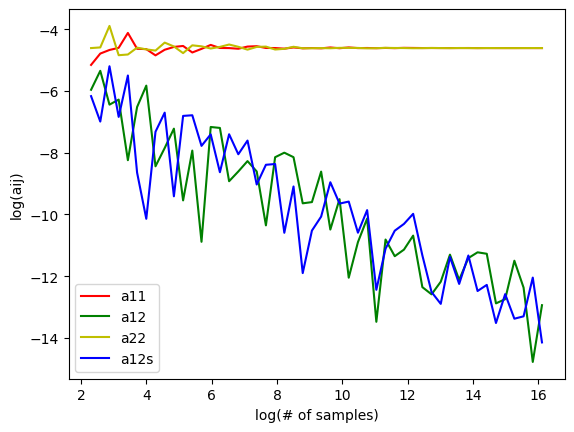

In [7]:
# covariance test by Martynas

mu,sigma = 0, 0.1

#array to hold sample numbers
num_samples = np.logspace(1,7,50)

#array to hold calculated covariances
covariances = []
covariances_s = []

#run a loop, where every cycle the number of samples taken from gaussian distribution is different
for num in num_samples:

    #draw IID gaussian distributed samples s1 and s2
    s1 = np.random.normal(mu, sigma, int(num))
    s2 = np.random.normal(mu, sigma, int(num))

    #define new variables f1,f2 in terms of s1,s2. Change a, b to see effect on covariances
    a = 1/np.sqrt(2)
    b = np.sqrt(1-a**2)
    f1 = a*s1 + b*s2
    f2 = a*s1 - b*s2
    
    fs1 = s1
    fs2 = s2


    f = [f1,f2]
    #calculated covariance of f1 and f2
    cov = np.cov(f)
    cov_merged = np.concatenate((cov[0],cov[1]),axis=None)
    #print(cov_merged)
    covariances.append(cov_merged)
    
    fs = [fs1,fs2]
    #calculated covariance of f1 and f2
    covs = np.cov(fs)
    covs_merged = np.concatenate((covs[0],covs[1]),axis=None)
    #print(cov_merged)
    covariances_s.append(covs_merged)

coefficients = np.array(covariances).T

samples = np.log(num_samples)

coefficients_s = np.array(covariances_s).T

a11 = np.log(np.abs(coefficients[0]))
a12 = np.log(np.abs(coefficients[1]))
a21 = np.log(np.abs(coefficients[2]))
a22 = np.log(np.abs(coefficients[3]))

a11s = np.log(np.abs(coefficients_s[0]))
a12s = np.log(np.abs(coefficients_s[1]))
a21s = np.log(np.abs(coefficients_s[2]))
a22s = np.log(np.abs(coefficients_s[3]))

plt.plot(samples, a11, color='r', label='a11')
plt.plot(samples, a12, color='g', label='a12')
# plt.plot(samples, a21, color='b', label='a21')
plt.plot(samples, a22, color='y', label='a22')

# plt.plot(samples, a12, color='r', label='a12')
# plt.plot(samples, a21, color='g', label='a21')
plt.plot(samples, a12s, color='b', label='a12s')
# plt.plot(samples, a21s, color='y', label='a21s')
  

plt.ylabel("log(aij)")
plt.xlabel("log(# of samples)")
plt.legend()

plt.show()

In [8]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

In [26]:
H2_op = get_qubit_op([0, 0.65])[0]
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SPSA(maxiter=100), SLSQP(maxiter=1000, disp=True)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
  
    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=quantum_instance)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimizer: SLSQP           Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1617597900091625
            Iterations: 38
            Function evaluations: 723
            Gradient evaluations: 38
Optimization complete      


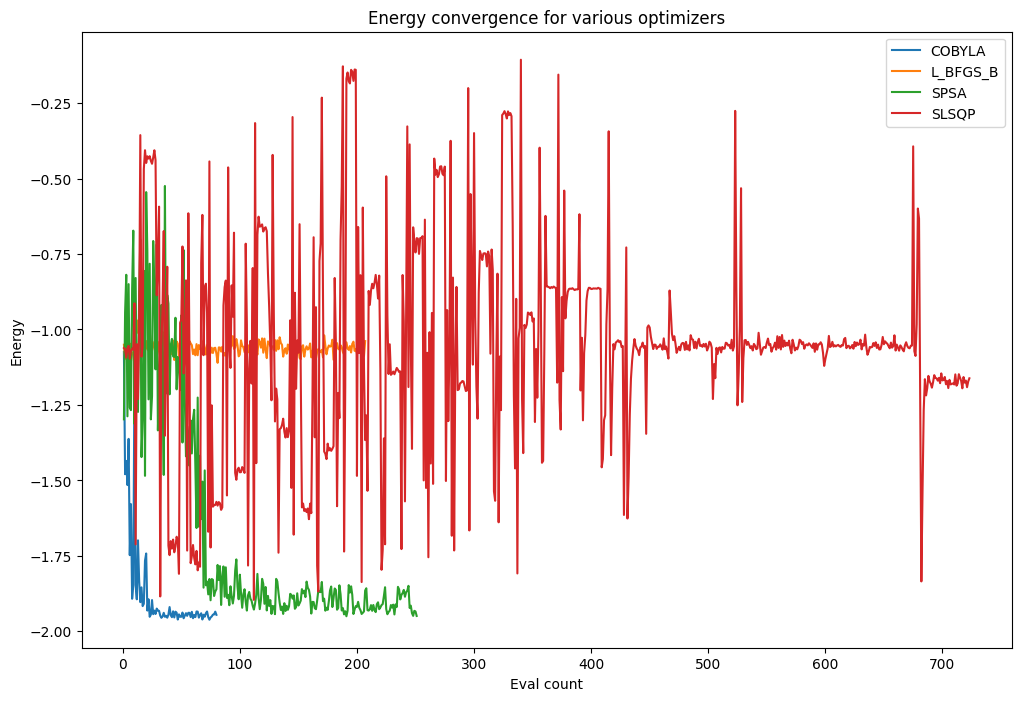

In [27]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

In [40]:
from functools import partial
from scipy.optimize import minimize

def calc_energy(op,num_part,num_orb,problem,converter):
    
    backend_exact = BasicAer.get_backend("statevector_simulator")
    quantum_instance_exact = QuantumInstance(backend_exact)
    
    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=1024)
    
    #no clue why this is needed. Without it the initial state has different # of qubits than the number of qubits in qubit operator
    # and we get an error. 
    result = exact_solver(problem,converter)

    optimizer = partial(minimize, method="COBYLA")
    optimizer2 = SPSA(maxiter=100)

        #result = exact_solver(problem,converter)
        #exact_energies.append(result.total_energies[0].real)
    
    init_state = HartreeFock(num_orb, num_part, converter)
   
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)
    
    vqe_cobyla = VQE(var_form, optimizer=optimizer, quantum_instance=quantum_instance)
    vqe_spsa = VQE(var_form, optimizer=optimizer2, quantum_instance=quantum_instance)
    vqe_exact = VQE(var_form, optimizer=optimizer, quantum_instance=quantum_instance_exact)
    
    vqe_calc1 = vqe_cobyla.compute_minimum_eigenvalue(op)
    vqe_result1 = problem.interpret(vqe_calc1).total_energies[0].real
    
    vqe_calc2 = vqe_spsa.compute_minimum_eigenvalue(op)
    vqe_result2 = problem.interpret(vqe_calc2).total_energies[0].real
    
    vqe_calc_exact = vqe_exact.compute_minimum_eigenvalue(op)
    vqe_result_exact = problem.interpret(vqe_calc_exact).total_energies[0].real
    
    return vqe_result1, vqe_result2, vqe_result_exact

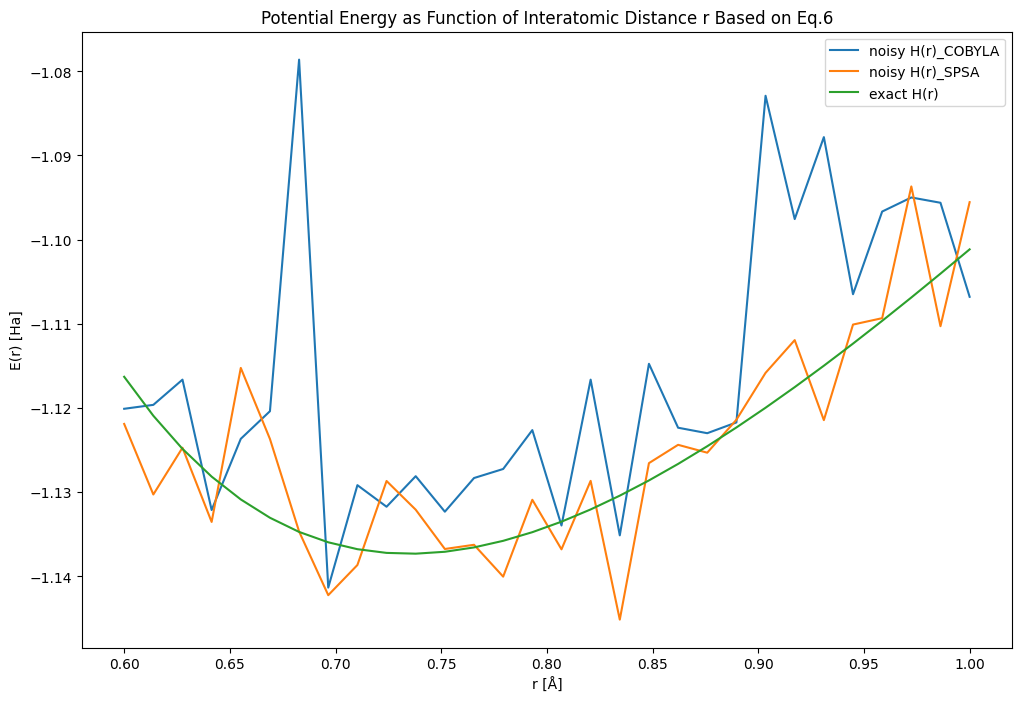

In [41]:
n = 30 # number of points
r = np.linspace(0.6,1.0,n)
forces = np.zeros(n)
potential1 = np.zeros(n)
potential2 = np.zeros(n)
potential_exact = np.zeros(n)

for x in range(n):
    dist = r[x]
    op, num_part, num_orb, problem, converter = get_qubit_op([0,dist])
    potential1[x], potential2[x], potential_exact[x]= calc_energy(op,num_part,num_orb,problem,converter)

plt.plot(r, potential1, label = 'noisy H(r)_COBYLA')
plt.plot(r, potential2, label = 'noisy H(r)_SPSA')
plt.plot(r, potential_exact, label = 'exact H(r)')

plt.title('Potential Energy as Function of Interatomic Distance r Based on Eq.6')
plt.xlabel('r [Å]')
plt.ylabel('E(r) [Ha]')
plt.legend()
plt.show()